In [1]:
using VMLS
using LinearAlgebra

## Chapter 15
# Multi-objective least squares
### 15.1 Multi-objective least squares
Let’s write a function that solves the multi-objective least squares problem, with
given positive weights. The data are a list (or array) of coefficient matrices (of
possibly different heights) `As`, a matching list of (right-hand side) vectors `bs`, and
the weights, given as an array or list, `lambdas`.

In [2]:
function mols_solve(As,bs,lambdas)
k = length(lambdas);
Atil = vcat([sqrt(lambdas[i])*As[i] for i=1:k]...)
btil = vcat([sqrt(lambdas[i])*bs[i] for i=1:k]...)
return Atil \ btil
end

mols_solve (generic function with 1 method)

**Simple example.** We use the function `mols_solve` to work out a bi-criterion
example similar to Figures [15.1](https://web.stanford.edu/~boyd/vmls/vmls.pdf#figure.15.1), [15.2](https://web.stanford.edu/~boyd/vmls/vmls.pdf#figure.15.2), and [15.3](https://web.stanford.edu/~boyd/vmls/vmls.pdf#figure.15.3) in VMLS. We minimize the weighted sum objective

$$
J_1 + λJ_2 = ‖A_1x− b_1‖^2 + λ‖A_2x− b_2‖^2
$$

for randomly chosen $10 × 5$ matrices $A_1, A_2$ and $10$-vectors $b_1$, $b_2$. The expression `lambdas = 10 .^ linspace(-4,4,200)` generates $200$ values of $λ ∈ [10^{−4}, 10^4]$, equally spaced on a logarithmic scale. The code creates the three plots in Figures [15.1](#fig_1), [15.2](#fig_2), and [15.3](#fig_3).

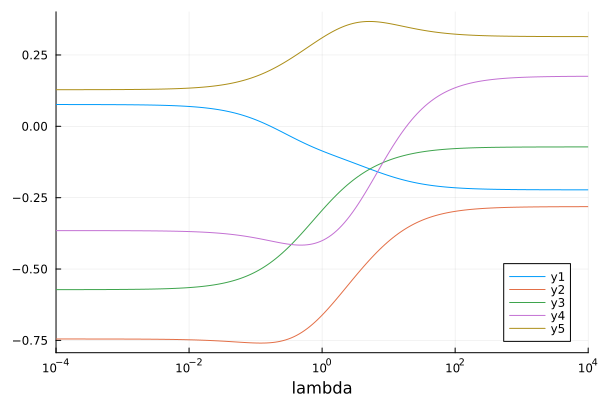

In [3]:
As = [randn(10,5), randn(10,5)];
bs = [randn(10), randn(10)];
N = 200;
lambdas = 10 .^ linspace(-4,4,200);
x = zeros(5,N); J1 = zeros(N); J2 = zeros(N);
for k = 1:N
    x[:,k] = mols_solve(As, bs, [1, lambdas[k]])
    J1[k] = norm(As[1]*x[:,k] - bs[1])^2
    J2[k] = norm(As[2]*x[:,k] - bs[2])^2
end;
using Plots
# plot solution versus lambda
plot(lambdas, x', xscale = :log10, xlabel = "lambda")
plot!(xlims = (1e-4,1e4))

**Figure 15.1** Weighted-sum least squares solution $x̂(λ)$ as a function of $λ$ for
a bi-criterion least squares problem with five variables.
<a id="#fig_1"></a>

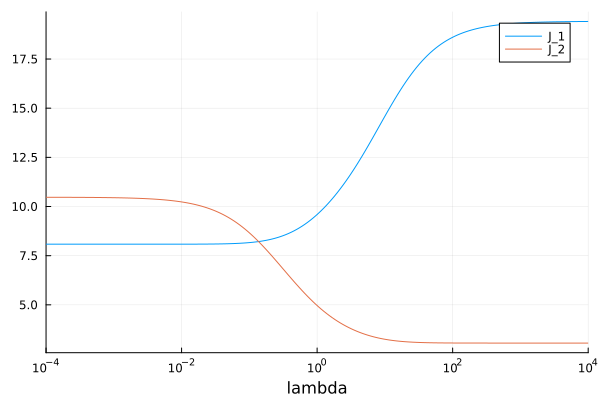

In [4]:
# plot two objectives versus lambda
plot(lambdas, J1, xscale = :log10, label = "J_1")
plot!(lambdas, J2, label = "J_2", xlabel = "lambda", xlims = (1e-4,1e4))

**Figure 15.2** Objective functions $J_1 = ‖A_1x̂(λ)b_1‖^2$ (blue line) and $J_2 =
‖A_2x̂(λ)b_2‖^2$ (red line) as functions of $λ$ for the bi-criterion problem in figure 15.1.
<a id="#fig_2"></a>

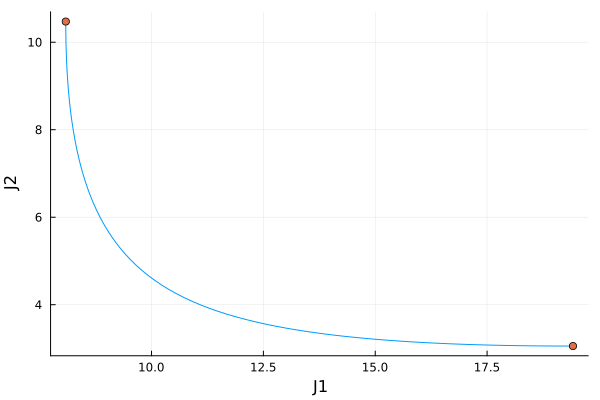

In [5]:
# plot trade-off curve
plot(J1, J2, xlabel="J1", ylabel = "J2", legend=false)
# add (single-objective) end points to trade-off curve
x1 = As[1] \ bs[1];
x2 = As[2] \ bs[2];
J1 = [norm(As[1]*x1-bs[1])^2, norm(As[1]*x2-bs[1])^2];
J2 = [norm(As[2]*x1-bs[2])^2, norm(As[2]*x2-bs[2])^2];
scatter!(J1,J2)

**Figure 15.3** Optimal trade-off curve for the bi-criterion least squares problem
of figures 15.1 and 15.2.
<a id="#fig_3"></a>

### 15.2 Control
### 15.3 Estimation and inversion
**Estimating a periodic time series.** We consider the example of Figure [15.4](https://web.stanford.edu/~boyd/vmls/vmls.pdf#figure.15.4) in
VMLS. We start by loading the data, as a vector with hourly ozone levels, for a
period of $14$ days. Missing measurements have a value `NaN` (for Not a Number).
The plot command skips those values (Figure [15.4](#fig_4)). 

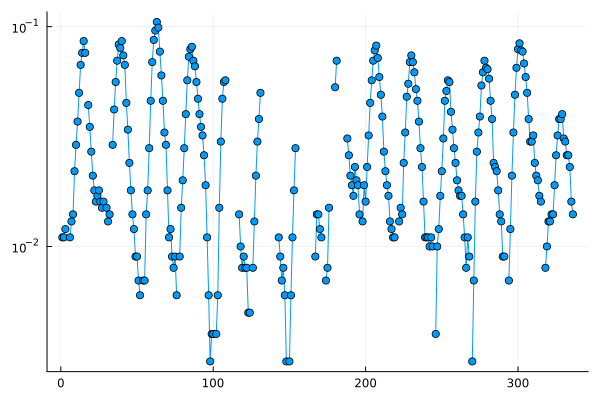

In [6]:
ozone = ozone_data(); # a vector of length 14*24 = 336
k = 14; N = k*24;
plot(1:N, ozone, yscale = :log10, marker = :circle, legend=false)

**Figure 15.4** Hourly ozone level at Azusa, California, during the first $14$ days of July $2014$ (California Environmental Protection Agency, Air Resources Board, www.arb.ca.gov). Measurements start at $12$AM on July $1$st, and end at $11$PM on July $14$. Note the large number of missing measurements. In particular, all $4$AM measurements are missing.
<a id="#fig_4"></a>

Next we use the `mols_solve` function to make a periodic fit, for the values
$λ = 1$ and $λ = 10$. The Julia code `isnan` is used to find and discard the missing
measurements. The results are shown in Figures [15.5](#fig_5) and [15.6](#fig_6).

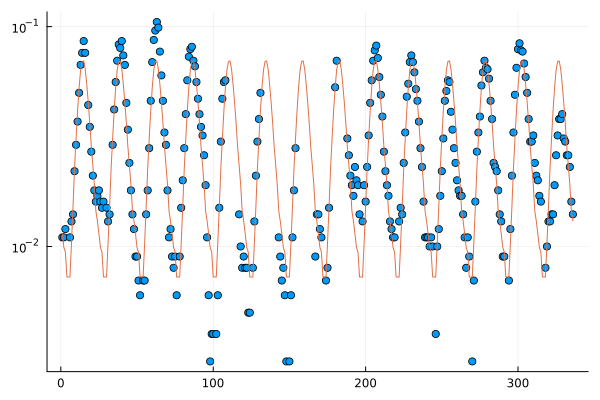

In [7]:
A = vcat( [eye(24) for i = 1:k]...)
# periodic difference matrix
D = -eye(24) + [zeros(23,1) eye(23); 1 zeros(1,23)];
ind = [k for k in 1:length(ozone) if !isnan(ozone[k])];
As = [A[ind,:], D]
bs = [log.(ozone[ind]), zeros(24)]
# solution for lambda = 1
x = mols_solve( As, bs, [1, 1])
scatter(1:N, ozone, yscale = :log10, legend=false)
plot!(1:N, vcat([exp.(x) for i = 1:k]...))

**Figure 15.5** Smooth periodic least squares fit to logarithmically transformed
measurements, using $λ = 1$.
<a id="#fig_5"></a>

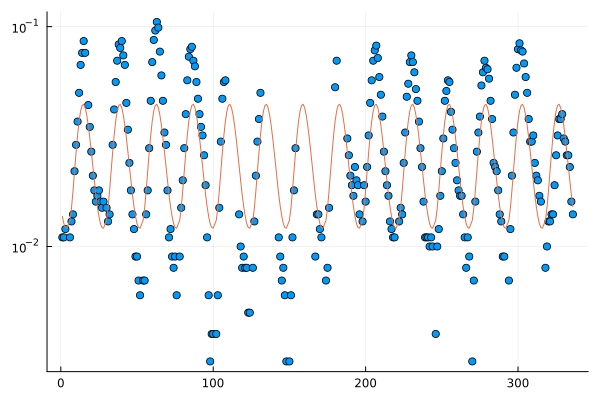

In [8]:
# solution for lambda = 100
x = mols_solve( As, bs, [1, 100])
scatter(1:N, ozone, yscale = :log10, legend=false)
plot!(1:N, vcat([exp.(x) for i = 1:k]...))

**Figure 15.6** Smooth periodic least squares fit to logarithmically transformed
measurements, using $λ = 100$.
<a id="#fig_6"></a>

### 15.4 Regularized data fitting
**Example.** Next we consider the small regularized data fitting example of page [329](https://web.stanford.edu/~boyd/vmls/vmls.pdf#section*.367) of VMLS. We fit a model

$$
f̂(x) =
\sum^5_{k=1}
θ_kf_k(x)
$$

with basis functions $f_1(x) = 1$ and $f_{k+1}(x) = sin(ω_kx + φ_k)$ for $k = 1, . . . , 4$ to $N = 20$ data points. We use the values of $ω_k$, $φ_k$ given in the text. We fit the model by solving a sequence of regularized least squares problems with objective

$$
\sum^N_{i=1}(y^{(i)} − \sum^5_{k=1} θ_kf_k(x^{(i)}))^2 + λ \sum^5_{k=2}θ^2_k.
$$

The two plots are shown in Figures [15.7](#fig_7) and [15.8](#fig_8).

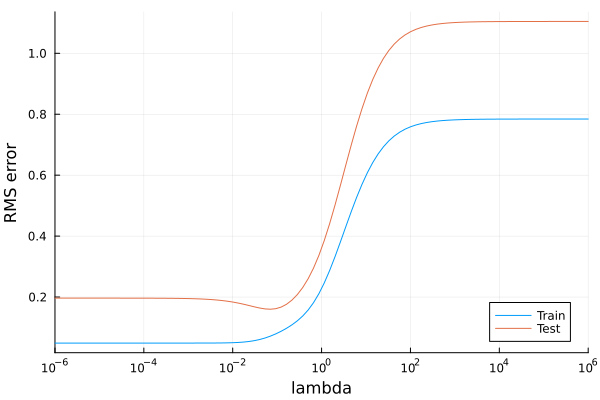

In [9]:
# Import data as vectors xtrain, ytrain, xtest, ytest
D = regularized_fit_data();
xtrain = D["xtrain"]; ytrain = D["ytrain"];
xtest = D["xtest"]; ytest = D["ytest"];
N = length(ytrain);
Ntest = length(ytest);
p = 5;
omega = [ 13.69; 3.55; 23.25; 6.03 ];
phi = [ 0.21; 0.02; -1.87; 1.72 ];
A = hcat(ones(N), sin.(xtrain*omega' + ones(N)*phi'));
Atest = hcat(ones(Ntest),
sin.(xtest*omega' + ones(Ntest)*phi'));
npts = 100;
lambdas = 10 .^ linspace(-6,6,npts);
err_train = zeros(npts);
err_test = zeros(npts);
thetas = zeros(p,npts);
for k = 1:npts
    theta = mols_solve([ A, [zeros(p-1) eye(p-1)]],
        [ ytrain, zeros(p-1) ], [1, lambdas[k]])
    err_train[k] = rms(ytrain - A*theta);
    err_test[k] = rms(ytest - Atest*theta);
    thetas[:,k] = theta;
end;
using Plots
# Plot RMS errors
plot(lambdas, err_train, xscale = :log10, label = "Train")
plot!(lambdas, err_test, xscale = :log10, label = "Test")
plot!(xlabel = "lambda", ylabel = "RMS error", xlim = (1e-6, 1e6))

**Figure 15.7** RMS training and test errors as a function of the regularization
parameter $λ$.

<a id="#fig_7"></a>

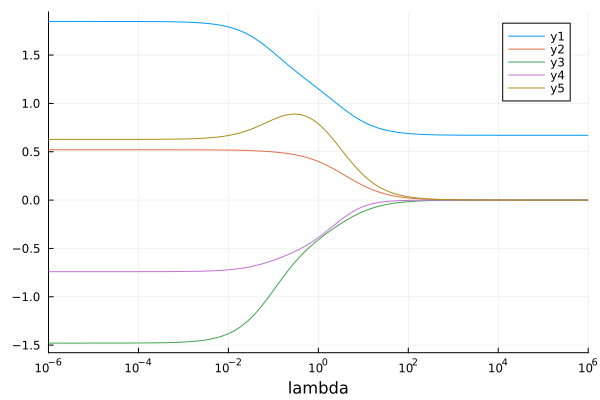

In [10]:
# Plot coefficients
plot(lambdas, thetas', xscale = :log10)
plot!(xlabel = "lambda", xlim = (1e-6, 1e6))

**Figure 15.8** The regularization path.
<a id="#fig_8"></a>

### 15.5 Complexity
**The kernel trick.** Let’s check the kernel trick, described in §[15.5.2](https://web.stanford.edu/~boyd/vmls/vmls.pdf#subsection.15.5.2), to find $x̂$, the minimizer of
$$
‖Ax− b‖^2 + λ‖x− x^{des}‖^2,
$$
where $A$ is an $m×n$ matrix and $λ > 0$. We’ll compute $x̂$ two ways. First, the naïve way, and then, using the kernel trick. We use the fact that if
$$
\begin{bmatrix}
A^T\\
\sqrt{λ}I
\end{bmatrix}
= QR,
$$
then
$$
(AA^T + λI)^{−1} = (R^TQ^TQR)^{−1} = R^{−1}R^−T .
$$

In [ ]:
m = 100; n = 5000;
A = randn(m,n); b = randn(m); xdes = randn(n);
lam = 2.0;
# Find x that minimizes ||Ax-b||^2 + lambda ||x||^2
@time xhat1 = [A; sqrt(lam)*eye(n)] \ [b; sqrt(lam)*xdes];
# Now use kernel trick
@time begin
Q, R = qr([A' ; sqrt(lam)*eye(m)]);
Q = Matrix(Q);
xhat2 = A' * (R \ (R' \ (b-A*xdes))) + xdes;
end;
norm(xhat1-xhat2)

The naïve method requires the factorization of a $5100 × 5100$ matrix. In the second
method we factor a matrix of size $5100 × 100$.